# Sequence Generation (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
!pip install datasets evaluate transformers[sentencepiece] -U
!pip install accelerate
!pip install -U pyarrow
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs
!pip install seqeval
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f794a5d252cc199d85afdd62c023d5c3b9d2422bd2a2726184a12b76cbcdab8a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


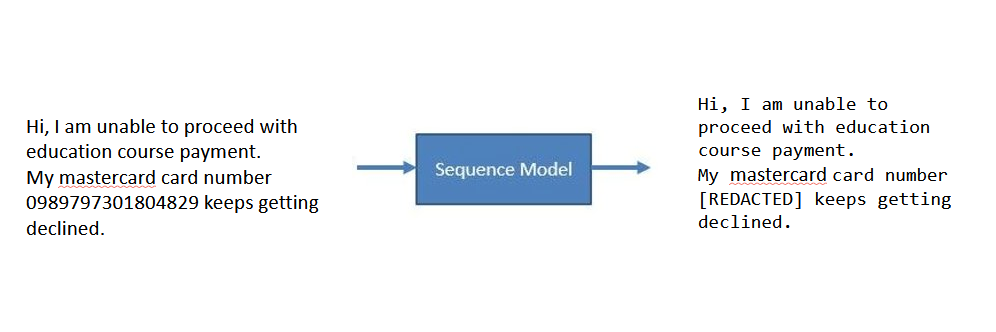

# Loading and Viewing Dataset

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("ai4privacy/pii-masking-200k", data_files=["english_pii_43k.jsonl"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text'],
        num_rows: 43501
    })
})

In [4]:
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
# Load the tokenizer, model, and data collator
MODEL_NAME = "google/flan-t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Filter Samples with only required Tags

In [5]:
import json
import ast
REQUIRED_TAGS = ['FIRSTNAME','MIDDLENAME','EMAIL', 'LASTNAME', 'CREDITCARDNUMBER', 'ZIPCODE', 'SSN', 'PHONENUMBER','CREDITCARDCVV']
from datasets import load_dataset

def filter_privacy_masks(row):
    try:
      mask_dict = ast.literal_eval(row['privacy_mask'])
      row['privacy_mask'] = json.dumps(mask_dict)
      new_mask_dict = {key:value for key, value in mask_dict.items() if key.strip('[]').split('_')[0] in REQUIRED_TAGS}
      row['new_privacy_mask'] = json.dumps(new_mask_dict)
      return row
    except Exception as e:
      print(e)
      row['new_privacy_mask'] = {}
      return row

new_mask_raw_dataset = raw_datasets.map(filter_privacy_masks, num_proc=4)
filtered_new_mask_raw_dataset = new_mask_raw_dataset.filter( lambda x : len(json.loads(x['new_privacy_mask'])) > 0)

In [6]:
filtered_new_mask_raw_dataset['train'][10]['privacy_mask']

'{"[CREDITCARDNUMBER_1]": "6381973478101820", "[IPV4_1]": "215.114.180.213", "[JOBTITLE_1]": "Investor Program Supervisor"}'

In [7]:
filtered_new_mask_raw_dataset['train'][10]['new_privacy_mask']

'{"[CREDITCARDNUMBER_1]": "6381973478101820"}'

In [8]:
filtered_new_mask_raw_dataset['train'][10]['masked_text']

"I've noticed some unusual activities related to the credit card number [CREDITCARDNUMBER_1]. The transactions are coming from the IP address [IPV4_1]. As our [JOBTITLE_1], could you please investigate?"

# Re filling Masked text of unwanted Labels

In [9]:
import re
class TextLabeler():
    def __init__(self, text, lod):
        self.text = text
        self.iterate(lod)

    def replace_kv(self, _dict):
        """Replace any occurrence of a value with the key"""
        for key, value in _dict.items():
          self.text = self.text.replace(key,value)
        return self.text

    def iterate(self, lod):
        """Iterate over each dict object in a given list of dicts, `lod` """

        self.text = self.replace_kv(lod)

def fill_unwanted_masks(example):
  old_mask_map = json.loads(example['privacy_mask'])
  new_mask_map = json.loads(example['new_privacy_mask'])
  replace_masks = {key : old_mask_map[key] for key in set(old_mask_map.keys()) - set(new_mask_map.keys())}
  processed = TextLabeler(example['masked_text'], replace_masks)
  Removed_unwanted_text= processed.text
  redact_masks = {key : "[REDACTED]" for key in set(new_mask_map.keys())}
  processed = TextLabeler(Removed_unwanted_text, redact_masks)
  example['new_masked_text'] = processed.text
  return(example)

new_mask_raw_dataset = filtered_new_mask_raw_dataset.map(lambda x: fill_unwanted_masks(x), num_proc=4)

In [10]:
new_mask_raw_dataset['train'][10]['unmasked_text']

"I've noticed some unusual activities related to the credit card number 6381973478101820. The transactions are coming from the IP address 215.114.180.213. As our Investor Program Supervisor, could you please investigate?"

In [11]:
new_mask_raw_dataset['train'][10]['new_masked_text']

"I've noticed some unusual activities related to the credit card number [REDACTED]. The transactions are coming from the IP address 215.114.180.213. As our Investor Program Supervisor, could you please investigate?"

In [12]:
def preprocess_function(examples):
   """Add prefix to the sentences, tokenize the text, and set the labels"""
   prompt = "Mask all sensitive information form the sentence like Name, SSN, Credit card information, Phone numbers, email address:\n"
   # The "inputs" are the tokenized answer:
   inputs = [prompt + doc for doc in examples["unmasked_text"]]
   model_inputs = tokenizer(inputs, max_length=512, truncation=True,padding=True,return_tensors='pt')

   # The "labels" are the tokenized outputs:
   labels = tokenizer(text_target=examples["new_masked_text"],
                      max_length=512,
                      truncation=True,
                      padding=True,
                      return_tensors='pt')

   model_inputs["labels"] = labels["input_ids"]
   return model_inputs

In [13]:
# Map the preprocessing function across our dataset
tokenized_dataset = new_mask_raw_dataset.map(preprocess_function, batched=True, remove_columns=['privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text', 'new_privacy_mask', 'new_masked_text'])

# Train Test Split

In [14]:
import torch
dataset = tokenized_dataset['train'].train_test_split(test_size=0.15)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=preprocess_function)

In [15]:
import nltk
import evaluate
import numpy as np
from nltk.tokenize import sent_tokenize
# Metric
nltk.download('punkt')
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
from transformers import DataCollatorForSeq2Seq

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [17]:
# Global Parameters
L_RATE = 3e-4
BATCH_SIZE = 8
gradient_accumulation = 8
PER_DEVICE_EVAL_BATCH = 4
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 2

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False,
   gradient_accumulation_steps = gradient_accumulation,
)

In [18]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=dataset["train"],
   eval_dataset=dataset["test"],
   tokenizer=tokenizer,
    data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,No log,0.001088,62.833800,60.717700,62.803300,62.827700,18.998349
1,0.319600,0.000815,62.861100,60.785500,62.837800,62.857600,18.997524


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=642, training_loss=0.2492578314193684, metrics={'train_runtime': 3885.1704, 'train_samples_per_second': 10.603, 'train_steps_per_second': 0.165, 'total_flos': 2.772753709400064e+16, 'train_loss': 0.2492578314193684, 'epoch': 1.99})

# Checking Performance of model

In [38]:
from transformers import pipeline
import textwrap

model = trainer.model
encoded_input = tokenizer("Hi Mrs. Berge, remember to make payment for today's session. Use 16-digit card 2949686653378210 CVV 555.",
                          return_tensors = "pt")
outputs = model.generate(encoded_input.input_ids.to("cuda:0"),max_new_tokens = 100)
wrapper = textwrap.TextWrapper(width=50)
string = wrapper.fill(text=tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])
print (string)

Hi Mrs. [REDACTED], remember to make payment for
today's session. Use 16-digit card [REDACTED] CVV
[REDACTED].


# Pipeline Output